In [125]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 
import numpy as np

In [126]:
df = pd.read_csv('car_details.csv')

In [127]:
df.head()

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner
0,Maruti 800 AC,2007,60000,70000,Petrol,Individual,Manual,First Owner
1,Maruti Wagon R LXI Minor,2007,135000,50000,Petrol,Individual,Manual,First Owner
2,Hyundai Verna 1.6 SX,2012,600000,100000,Diesel,Individual,Manual,First Owner
3,Datsun RediGO T Option,2017,250000,46000,Petrol,Individual,Manual,First Owner
4,Honda Amaze VX i-DTEC,2014,450000,141000,Diesel,Individual,Manual,Second Owner


In [128]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4340 entries, 0 to 4339
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   name           4340 non-null   object
 1   year           4340 non-null   int64 
 2   selling_price  4340 non-null   int64 
 3   km_driven      4340 non-null   int64 
 4   fuel           4340 non-null   object
 5   seller_type    4340 non-null   object
 6   transmission   4340 non-null   object
 7   owner          4340 non-null   object
dtypes: int64(3), object(5)
memory usage: 271.4+ KB


In [129]:
pd.options.display.float_format = '{:.2f}'.format
df.describe()

,year,selling_price,km_driven
count,4340.00,4340.00,4340.00
mean,2013.09,504127.31,66215.78
std,4.22,578548.74,46644.10
min,1992.00,20000.00,1.00
25%,2011.00,208749.75,35000.00
50%,2014.00,350000.00,60000.00
75%,2016.00,600000.00,90000.00
max,2020.00,8900000.00,806599.00


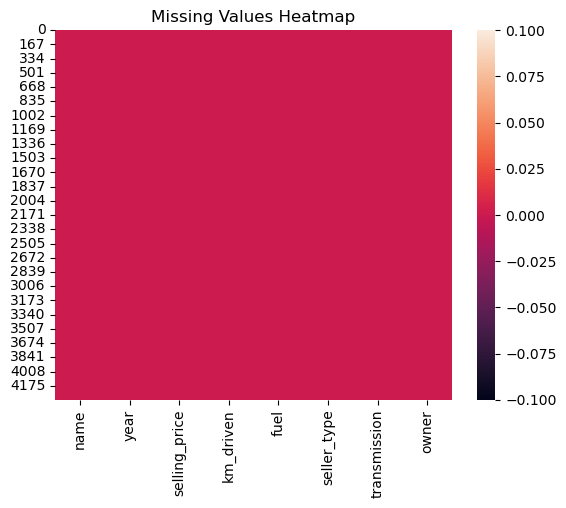

In [130]:
sns.heatmap(df.isnull(),cbar=True)
plt.title('Missing Values Heatmap')
plt.show()

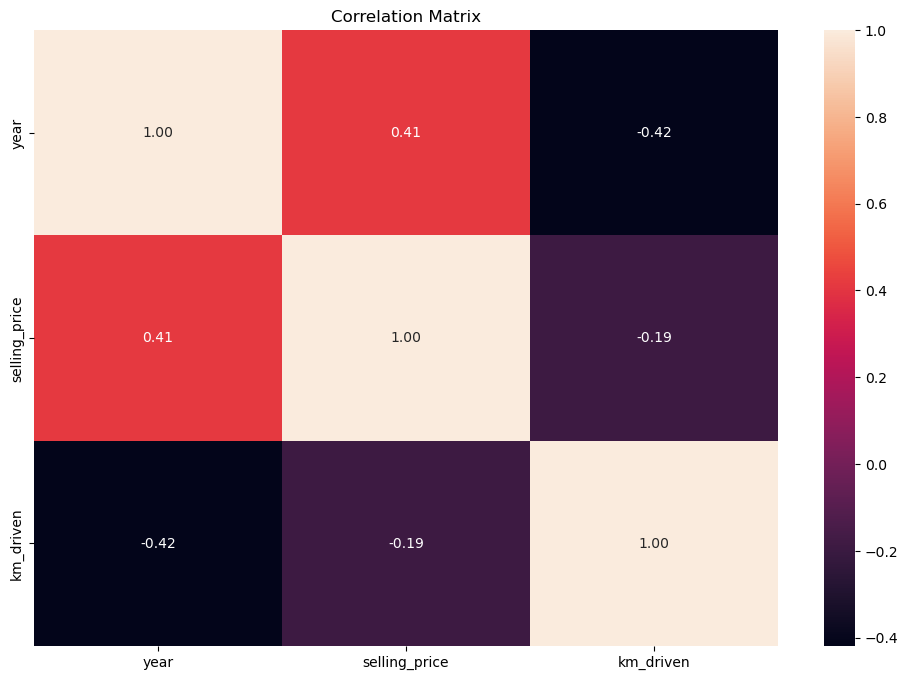

In [131]:
plt.figure(figsize=(12,8))
sns.heatmap(df.select_dtypes(include='number').corr(),annot=True,fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

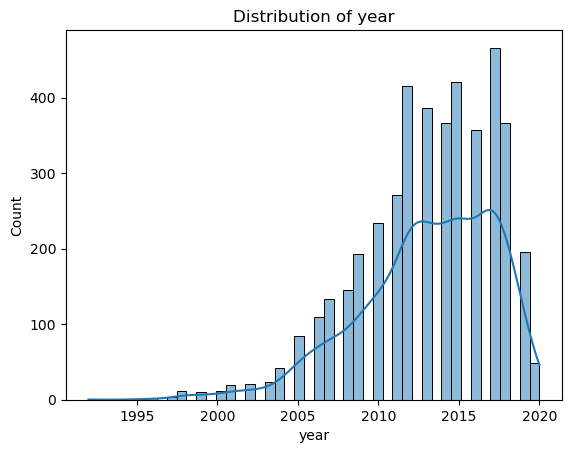

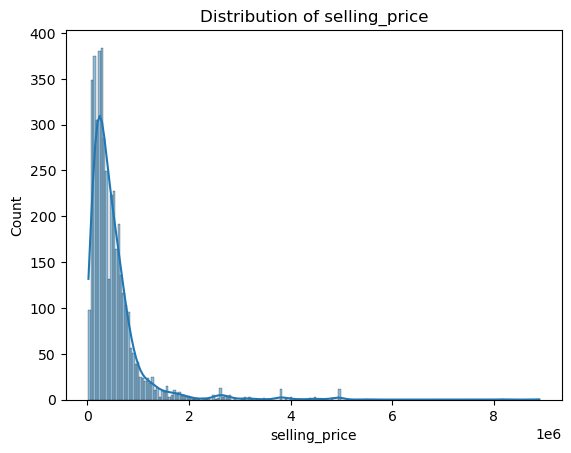

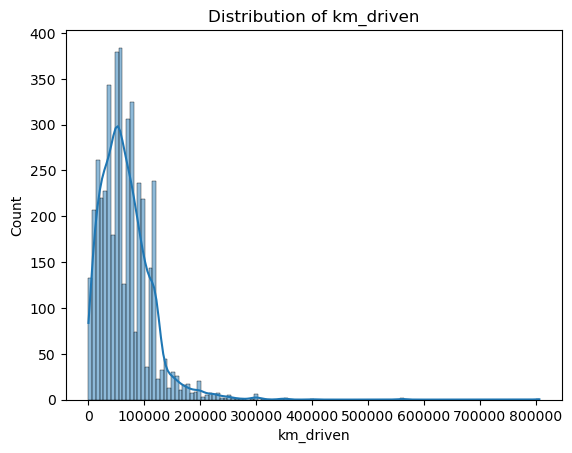

In [132]:
for col in df.select_dtypes(include='number').columns:
    sns.histplot(df[col],kde=True)
    plt.title(f'Distribution of {col}')
    plt.show()

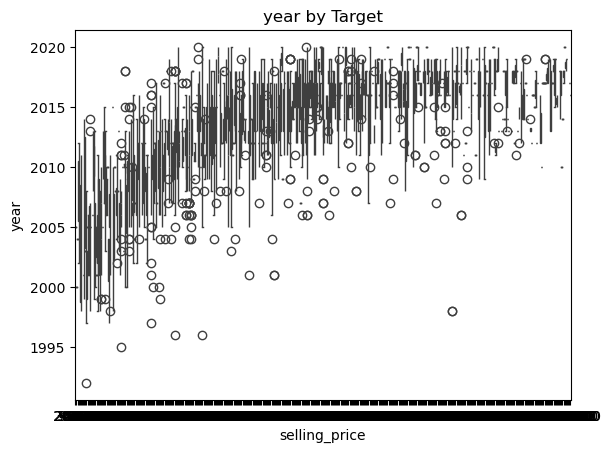

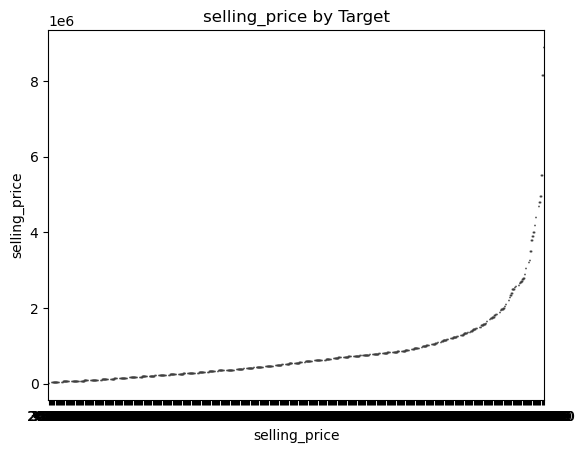

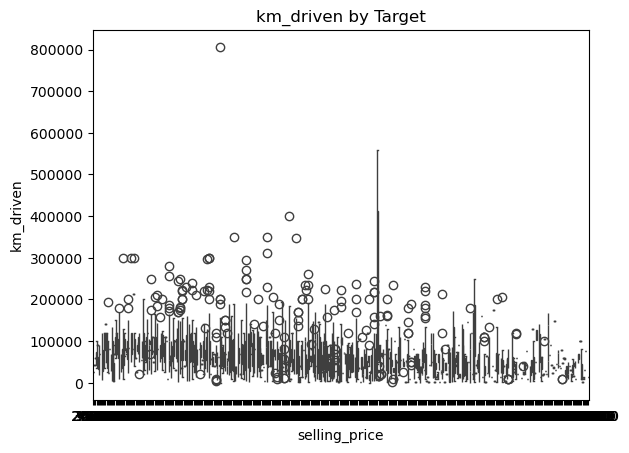

In [133]:
for col in df.select_dtypes(include='number').columns:
    sns.boxplot(x='selling_price',y=col,data=df)
    plt.title(f'{col} by Target')
    plt.show()

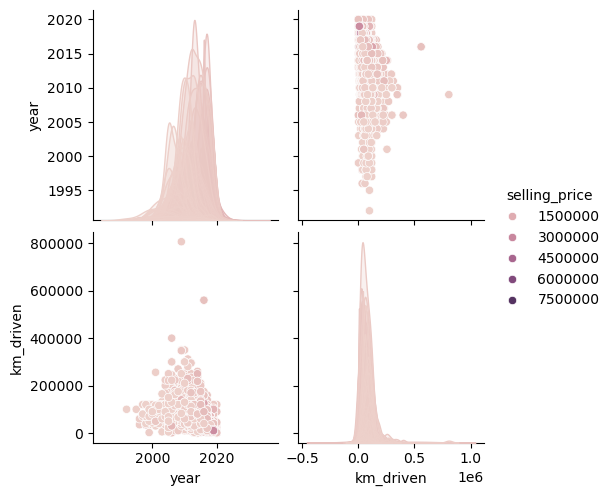

In [134]:
sns.pairplot(df,hue='selling_price')
plt.show()

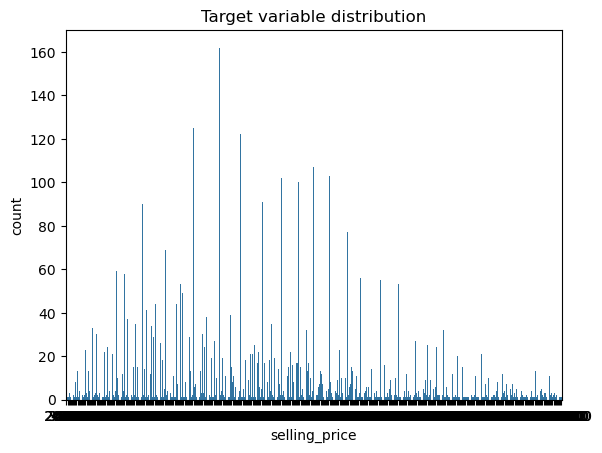

In [135]:
sns.countplot(x='selling_price',data=df)
plt.title('Target variable distribution')
plt.show()

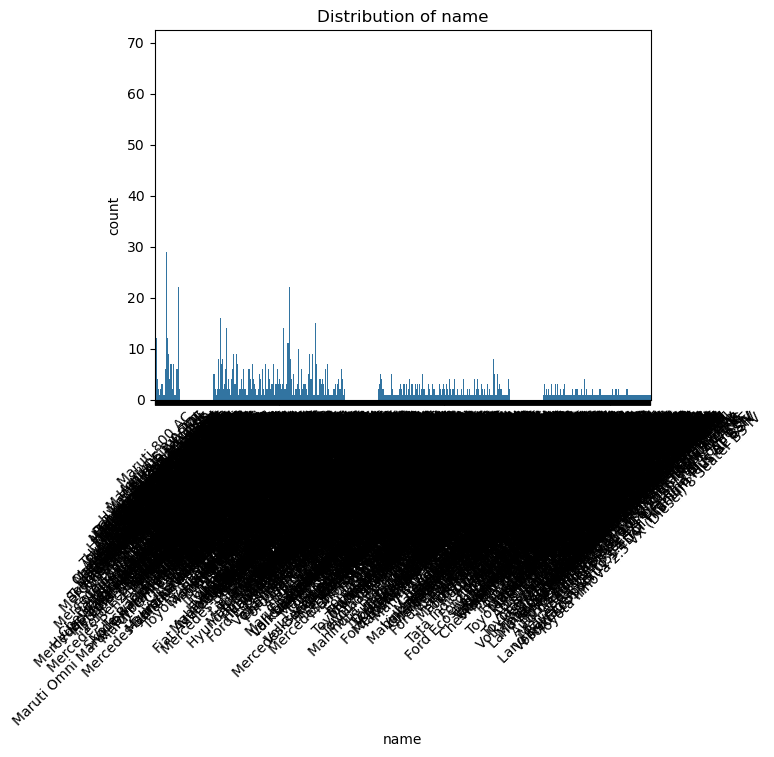

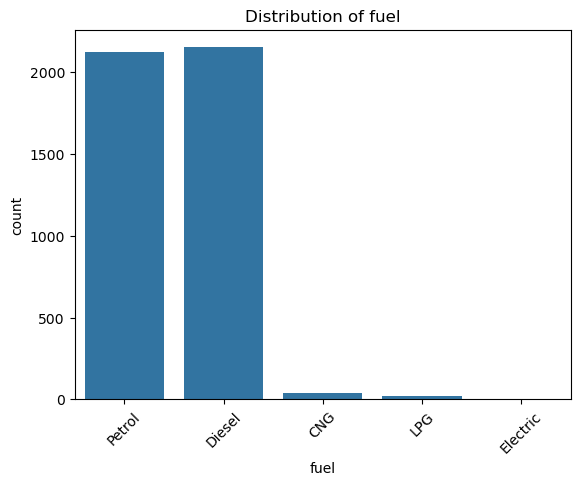

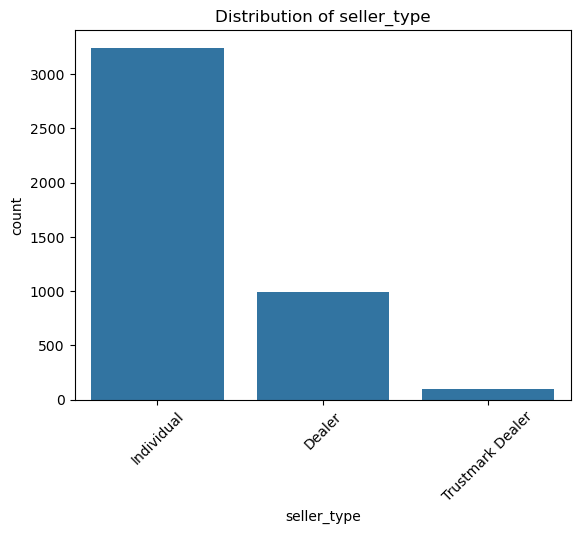

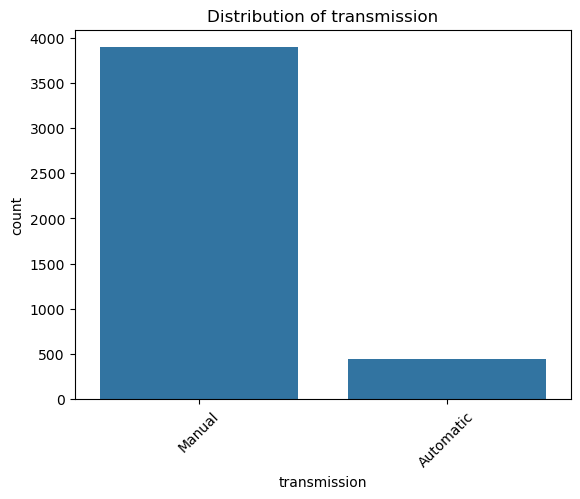

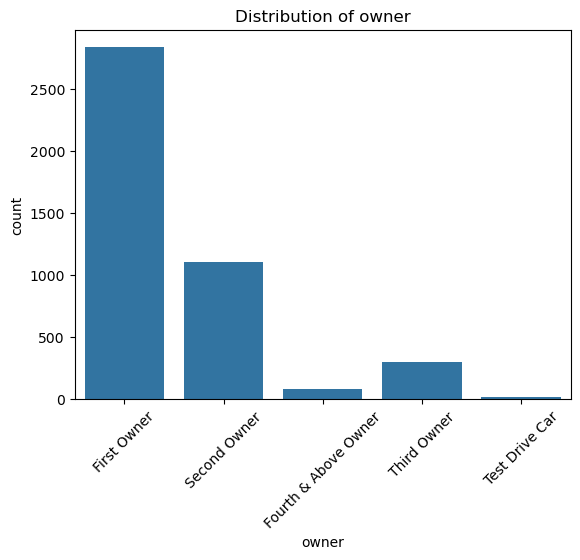

In [136]:
for col in df.select_dtypes(include='object').columns:
    sns.countplot(x=col,data=df)
    plt.title(f'Distribution of {col}')
    plt.xticks(rotation=45)
    plt.show()

<Axes: ylabel='selling_price'>

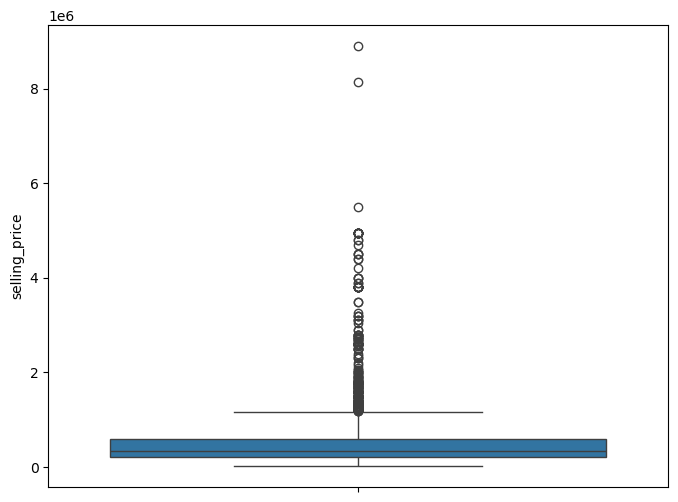

In [137]:
plt.figure(figsize=(8, 6))
sns.boxplot(y=df['selling_price'])

In [138]:
df.head()

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner
0,Maruti 800 AC,2007,60000,70000,Petrol,Individual,Manual,First Owner
1,Maruti Wagon R LXI Minor,2007,135000,50000,Petrol,Individual,Manual,First Owner
2,Hyundai Verna 1.6 SX,2012,600000,100000,Diesel,Individual,Manual,First Owner
3,Datsun RediGO T Option,2017,250000,46000,Petrol,Individual,Manual,First Owner
4,Honda Amaze VX i-DTEC,2014,450000,141000,Diesel,Individual,Manual,Second Owner


In [140]:
'''	
All encoding/transaformations/scaling

selling_price : log transform
km_driven : log transform
fuel : one hot encoding
seller_type	: one hot encoding
transmission : one hot encoding
owner : one hot encoding
car_age	: created from year by taking difference from 2020
brand_grouped : one hot encoding
'''

'\t\nAll encoding/transaformations/scaling\n\nselling_price : log transform\nkm_driven : log transform\nfuel : one hot encoding\nseller_type\t: one hot encoding\ntransmission : one hot encoding\nowner : one hot encoding\ncar_age\t: created from year by taking difference from 2020\nbrand_grouped : one hot encoding\n'

In [149]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder,FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.compose import TransformedTargetRegressor
from sklearn.metrics import root_mean_squared_error,r2_score

In [142]:
#transformations
df['car_age'] = 2020 - df['year']

df['brand']=df['name'].str.split().str[0]
brand_counts = df['brand'].value_counts()
threshold = 50
major_brands = list(brand_counts[brand_counts>=threshold].index)
df['brand_grouped'] = df['brand'].apply(lambda x: x if x in major_brands else 'Others')

In [143]:
features = ['km_driven','fuel','seller_type','transmission','owner','car_age','brand_grouped']
target = 'selling_price'

X=df[features]
y=df[target]

In [144]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=42)

In [145]:
num_features = ['km_driven']
cat_features = ['fuel','seller_type','transmission','owner','car_age','brand_grouped']

In [146]:
log_t = FunctionTransformer(func=np.log1p, inverse_func=np.expm1,validate=False)
ohe = OneHotEncoder(drop='first',sparse_output=False,handle_unknown='ignore')

num_pipeline = Pipeline([
   ('log', log_t)
])
cat_pipeline = Pipeline([
    ('encoder',ohe)
])

preprocessor = ColumnTransformer([
    ('num',num_pipeline,num_features),
    ('cat',cat_pipeline,cat_features)
])

regression_pipeline = Pipeline([
    ('preprocessing',preprocessor),
    ('model',LinearRegression())
])

full_model = TransformedTargetRegressor(
    regressor=regression_pipeline,
    func=log_t.transform,
    inverse_func=log_t.inverse_transform
)

In [147]:
full_model.fit(X_train,y_train)

TransformedTargetRegressor(func=<bound method FunctionTransformer.transform of FunctionTransformer(func=<ufunc 'log1p'>, inverse_func=<ufunc 'expm1'>)>,
                           inverse_func=<bound method FunctionTransformer.inverse_transform of FunctionTransformer(func=<ufunc 'log1p'>, inverse_func=<ufunc 'expm1'>)>,
                           regressor=Pipeline(steps=[('preprocessing',
                                                      ColumnTransformer(transformers=[('num',
                                                                                       Pipeline(steps=[('log',
                                                                                                        FunctionTransformer(func=<ufunc 'log1p'>,
                                                                                                                            inverse_func=<ufunc 'expm1'>))]),
                                                                                       ['km_driven']),
                                                                                      ('cat',
                                                                                       Pipeline(steps=[('encoder',
                                                                                                        OneHotEncoder(drop='first',
                                                                                                                      handle_unknown='ignore',
                                                                                                                      sparse_output=False))]),
                                                                                       ['fuel',
                                                                                        'seller_type',
                                                                                        'transmission',
                                                                                        'owner',
                                                                                        'car_age',
                                                                                        'brand_grouped'])])),
                                                     ('model',
                                                      LinearRegression())]))

In [148]:
y_pred = full_model.predict(X_test)

In [150]:
rmse = root_mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse:.2f}")
print(f"R² Score: {r2:.4f}")


RMSE: 341946.10
R² Score: 0.6045
